In [61]:
# Load all of the things
import tkinter as tk
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib
import sys
import matplotlib.pyplot as plt
import peakutils
from scipy.signal import savgol_filter  # for smoothing data
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
from mpl_toolkits.mplot3d import Axes3D
from peakutils.plot import plot as pplot
from tkinter import filedialog  # For folder input popup
matplotlib.rc('axes.formatter', useoffset=False)
%matplotlib inline

root = tk.Tk()
root.withdraw()

######################################################################
# Data Extraction
######################################################################
trial_info = pd.read_csv(r'C:\Users\Kara\PycharmProjects\FishTrackProcessing\Data\Trial_info.csv',
                         sep=',')
trial_info = trial_info.set_index('Trial_name')

# Comment out for user input
folder = r'C:\Users\Kara\PycharmProjects\FishTrackProcessing\Data'

#  Uncomment for User Input
# folder = filedialog.askdirectory()  #Ask user for directory
# framerate = float(input('Enter frame rate in frames per second:'))

# Initialize a list of dictionaries to contain each trial's data
tracklist = {}
count = 0  # Initialize the count

for filename in os.listdir(folder):  # For all files in the directory
    if filename.endswith("xypts.csv"):  # that end with 'xypts.csv'
     
        # Extract info from filename
        filepath = folder + '/' + filename
        file_info = filename.split("_")
        fish = file_info[0]
        sequence = file_info[1]
        trial_name = fish+sequence
        framerate = trial_info['FPS'][trial_name]
        L_calib = trial_info['ScaleL_cm/px'][trial_name]
        V_calib = trial_info['ScaleV_cm/px'][trial_name]
        init_Speed = trial_info['InitialSpd_cm'][trial_name]
        fish_TL = trial_info['Fish_TL_cm'][trial_name]
        behavior = trial_info['Behavior'][trial_name]

        df = pd.read_csv(filepath, sep=',')
        df = df.rename(columns={'pt1_cam1_Y': 'pt1z', 'pt1_cam2_X': 'pt1x',
                                'pt1_cam2_Y': 'pt1y', 'pt2_cam1_Y': 'pt2z',
                                'pt2_cam2_X': 'pt2x', 'pt2_cam2_Y': 'pt2y'})

        # Convert position to cm
        df['pt1z'] = df['pt1z']*L_calib
        df['pt1x'] = df['pt1x']*V_calib
        df['pt1y'] = df['pt1y']*V_calib
        df['pt2z'] = df['pt2z']*L_calib
        df['pt2x'] = df['pt2x']*V_calib
        df['pt2y'] = df['pt2y']*V_calib

        # Generate time array
        df['time'] = np.linspace(0, len(df['pt1x'])*(1.0/framerate),
                                 num=len(df['pt1x']), endpoint=False)
        df = df.set_index(['time'])
       
        # Smooth position data using savitzky golay
        df['pt1x_smth'] = scipy.signal.savgol_filter(
            df['pt1x'], window_length=121, polyorder=2)
        df['pt1y_smth'] = scipy.signal.savgol_filter(
            df['pt1y'], window_length=121, polyorder=2)
        df['pt1z_smth'] = scipy.signal.savgol_filter(
            df['pt1z'], window_length=121, polyorder=2)
        
        df['pt2x_smth'] = scipy.signal.savgol_filter(
            df['pt2x'], window_length=121, polyorder=2)
        df['pt2y_smth'] = scipy.signal.savgol_filter(
            df['pt2y'], window_length=121, polyorder=2)
        df['pt2z_smth'] = scipy.signal.savgol_filter(
            df['pt2z'], window_length=121, polyorder=2)
        
        # Calculate First Discrete Differences (Velocity)     
        cols_to_use1 = ['pt1x_smth', 'pt1y_smth', 'pt1z_smth', 'pt2x_smth',
                        'pt2y_smth', 'pt2z_smth']
        df2 = df.loc[:, cols_to_use1].diff()
        df2 = df2.rename(columns={
            'pt1z_smth': 'pt1z_v', 'pt1x_smth': 'pt1x_v',
            'pt1y_smth': 'pt1y_v', 'pt2z_smth': 'pt2z_v',
            'pt2x_smth': 'pt2x_v', 'pt2y_smth': 'pt2y_v'})
       
        df2['pt1x_v'] = -df2['pt1x_v']
        df2['pt1y_v'] = -df2['pt1y_v']
        df2['pt1z_v'] = -df2['pt1z_v']
        df2['pt2x_v'] = -df2['pt2x_v']
        df2['pt2y_v'] = -df2['pt2y_v']
        df2['pt2z_v'] = -df2['pt2z_v']

        # Add initial x-velocity
        df2['pt1x_v'] = df2['pt1x_v'].add(init_Speed)  
        df2['pt2x_v'] = df2['pt2x_v'].add(init_Speed)  
        
        # Smooth velocity data using savitzky golay
        df2['pt1x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1x_v'], window_length=121, polyorder=3)
        df2['pt1y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1y_v'], window_length=121, polyorder=3)
        df2['pt1z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1z_v'], window_length=121, polyorder=3)

        df2['pt2x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2x_v'], window_length=121, polyorder=3)
        df2['pt2y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2y_v'], window_length=121, polyorder=3)
        df2['pt2z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2z_v'], window_length=121, polyorder=3)
        
        # Calculate Second Discrete Differences (Acceleration)   
        cols_to_use2 = ['pt1x_v_smth', 'pt1y_v_smth', 'pt1z_v_smth',
                        'pt2x_v_smth', 'pt2y_v_smth', 'pt2z_v_smth']
        df3 = df2.loc[:, cols_to_use2].diff()
        df3 = df3.rename(columns={
            'pt1z_v_smth': 'pt1z_a', 'pt1x_v_smth': 'pt1x_a',
            'pt1y_v_smth': 'pt1y_a', 'pt2z_v_smth': 'pt2z_a',
            'pt2x_v_smth': 'pt2x_a', 'pt2y_v_smth': 'pt2y_a'})

        # Merge all this shit
        df = df.merge(df2, how='outer', right_index=True, left_index=True)
        df = df.merge(df3, how='outer', left_index=True, right_index=True)
        
        # Put all of these into the appropriate object in tracklist
        tracklist[trial_name] = {'sequence': trial_name, 'fish': fish,
                                 'fish_TL': fish_TL, 'FPS': framerate,
                                 'behavior': behavior,
                                 'data': df}
        
        # Advance the count
        count = count + 1


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

In [62]:
# Load all of the things
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('axes.formatter', useoffset=False)

def plot_tracks(tracklist_subset, tracklist):
    # TODO
    """Plot the 3D position, streamwise velocity, and streamwise accel of the
        snout and the tail tip from data as produced
        by process_points_pandas.py.

       Parameters
       ----------
       tracklist_subset : 1D array_like
           List of strings indicating sequence names of desired trials.         
       tracklist : pandas dataframe
           tracklist dataframe produced by process_points_pandas.py

       Returns
       -------

       Notes
       -----


       References
       ----------

       Examples
       --------
       """

    for trial in tracklist_subset:  # Iterates over all available trials

        # Scale time for colormap
        scaled_time = (tracklist[trial]['data'].index.values -
                       tracklist[trial]['data'].index.values.min()) / \
                      tracklist[trial]['data'].index.values.ptp()
        timemax = max(tracklist[trial]['data'].index.values)

        # Determining axis limits
        pt1max_v = tracklist[trial]['data']['pt1x_v_smth'].max()
        pt1min_v = tracklist[trial]['data']['pt1x_v_smth'].min()
        pt1max_a = tracklist[trial]['data']['pt1x_a'].max()
        pt1min_a = tracklist[trial]['data']['pt1x_a'].min()
        pt1_vbuff = (pt1max_v-pt1min_v)*0.05
        pt1_abuff = (pt1max_a-pt1min_a)*0.05
        pt1_vmaxlim = pt1max_v+pt1_vbuff
        pt1_vminlim = pt1min_v-pt1_vbuff
        pt1_amaxlim = pt1max_a+pt1_abuff
        pt1_aminlim = pt1min_a-pt1_abuff


        
        pt2max_v = tracklist[trial]['data']['pt2x_v_smth'].max()
        pt2min_v = tracklist[trial]['data']['pt2x_v_smth'].min()
        pt2max_a = tracklist[trial]['data']['pt2x_a'].max()
        pt2min_a = tracklist[trial]['data']['pt2x_a'].min()
        pt2_vbuff = (pt2max_v-pt2min_v)*0.05
        pt2_abuff = (pt2max_a-pt2min_a)*0.05
        pt2_vmaxlim = pt2max_v+pt2_vbuff
        pt2_vminlim = pt2min_v-pt2_vbuff
        pt2_amaxlim = pt2max_a+pt2_abuff
        pt2_aminlim = pt2min_a-pt2_abuff
    


        # Pull from colormap (here cubehelix)
        colors = plt.cm.cubehelix(scaled_time)

        # Raw Plot Pt 1, 3D
        fig = plt.figure()
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.suptitle(tracklist[trial]['sequence'] + ' ' + tracklist[trial]['behavior'])
        ax1 = fig.add_subplot(4, 2, 1, projection='3d')
        ax1.set_title('Pt 1 Raw Position')
        ax1.scatter3D(xs=tracklist[trial]['data']['pt1x'],
                         ys=tracklist[trial]['data']['pt1y'],
                         zs=tracklist[trial]['data']['pt1z'],
                         zdir='z', s=3, c=colors, marker='o',
                         edgecolor='none')  # 3D Scatter plot
        ax1.autoscale(enable=True, tight=True)
        ax1.set_xlabel('X position')
        ax1.set_ylabel('Y position')
        ax1.set_zlabel('Z position')
        m = cm.ScalarMappable(cmap=cm.cubehelix)
        m.set_array(tracklist[trial]['data'].index.values)
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Raw Plot Pt 2, 3D
        ax2 = fig.add_subplot(4, 2, 2, projection='3d')
        ax2.set_title('Pt 2 Raw Position')
        ax2.scatter3D(xs=tracklist[trial]['data']['pt2x'],
                          ys=tracklist[trial]['data']['pt2y'],
                          zs=tracklist[trial]['data']['pt2z'],
                          zdir='z', s=3, c=colors, marker='o',
                          edgecolor='none')  # 3D Scatter plot
        ax2.autoscale(enable=True, tight=True)
        ax2.set_xlabel('X position')
        ax2.set_ylabel('Y position')
        ax2.set_zlabel('Z position')
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Smoothed Data Pt 1, 3D
        ax3 = fig.add_subplot(4, 2, 3, projection='3d')
        ax3.set_title('Pt 1 Smoothed Position')
        ax3.scatter3D(xs=tracklist[trial]['data']['pt1x_smth'],
                          ys=tracklist[trial]['data']['pt1y_smth'],
                          zs=tracklist[trial]['data']['pt1z_smth'],
                          zdir='z', s=3, c=colors, marker='o',
                          edgecolor='none')  # Scatter plot
        ax3.autoscale(enable=True, tight=True)
        ax3.set_xlabel('X position')
        ax3.set_ylabel('Y position')
        ax3.set_zlabel('Z position')
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Smoothed Data Pt 2, 3D
        ax4 = fig.add_subplot(4, 2, 4, projection='3d')
        ax4.set_title('Pt 2 Smoothed Position')
        ax4.scatter3D(xs=tracklist[trial]['data']['pt2x_smth'],
                          ys=tracklist[trial]['data']['pt2y_smth'],
                          zs=tracklist[trial]['data']['pt2z_smth'],
                          zdir='z', s=3, c=colors, marker='o',
                          edgecolor='none')  # Scatter plot
        ax4.autoscale(enable=True, tight=True)
        ax4.set_xlabel('X position')
        ax4.set_ylabel('Y position')
        ax4.set_zlabel('Z position')
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Streamwise Velocity Pt 1
        ax5 = fig.add_subplot(4, 2, 5)
        ax5.set_title('Pt 1 Streamwise Velocity')
        plt.scatter(x=tracklist[trial]['data'].index.values,
                    y=tracklist[trial]['data']['pt1x_v_smth'],
                    c=colors, edgecolor='none')
        ax5.set_xlim([0,timemax])
        ax5.set_ylim([pt1_vminlim, pt1_vmaxlim])
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Streamwise Velocity Pt 2
        ax6 = fig.add_subplot(4, 2, 6)
        ax6.set_title('Pt 2 Streamwise Velocity')
        plt.scatter(x=tracklist[trial]['data'].index.values,
                    y=tracklist[trial]['data']['pt2x_v_smth'],
                    c=colors, edgecolor='none')
        ax6.set_xlim([0, timemax])
        ax6.set_ylim([pt2_vminlim, pt2_vmaxlim])
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Streamwise Accel Pt 1
        ax7 = fig.add_subplot(4, 2, 7)
        ax7.set_title('Pt 1 Streamwise Acceleration')
        plt.scatter(x=tracklist[trial]['data'].index.values,
                    y=tracklist[trial]['data']['pt1x_a'],
                    c=colors, edgecolor='none')
        ax7.set_xlim([0,timemax])
        ax7.set_ylim([pt1_aminlim, pt1_amaxlim])
        plt.colorbar(m, shrink=0.5, aspect=10)

        # Streamwise Accel Pt 2
        ax8 = fig.add_subplot(4, 2, 8)
        ax8.set_title('Pt 2 Streamwise Acceleration')
        plt.scatter(x=tracklist[trial]['data'].index.values,
                    y=tracklist[trial]['data']['pt2x_a'],
                    c=colors, edgecolor='none')
        ax8.set_xlim([0,timemax])
        ax8.set_ylim([pt2_aminlim, pt2_amaxlim])
        plt.colorbar(m, shrink=0.5, aspect=10)
        plt.show()

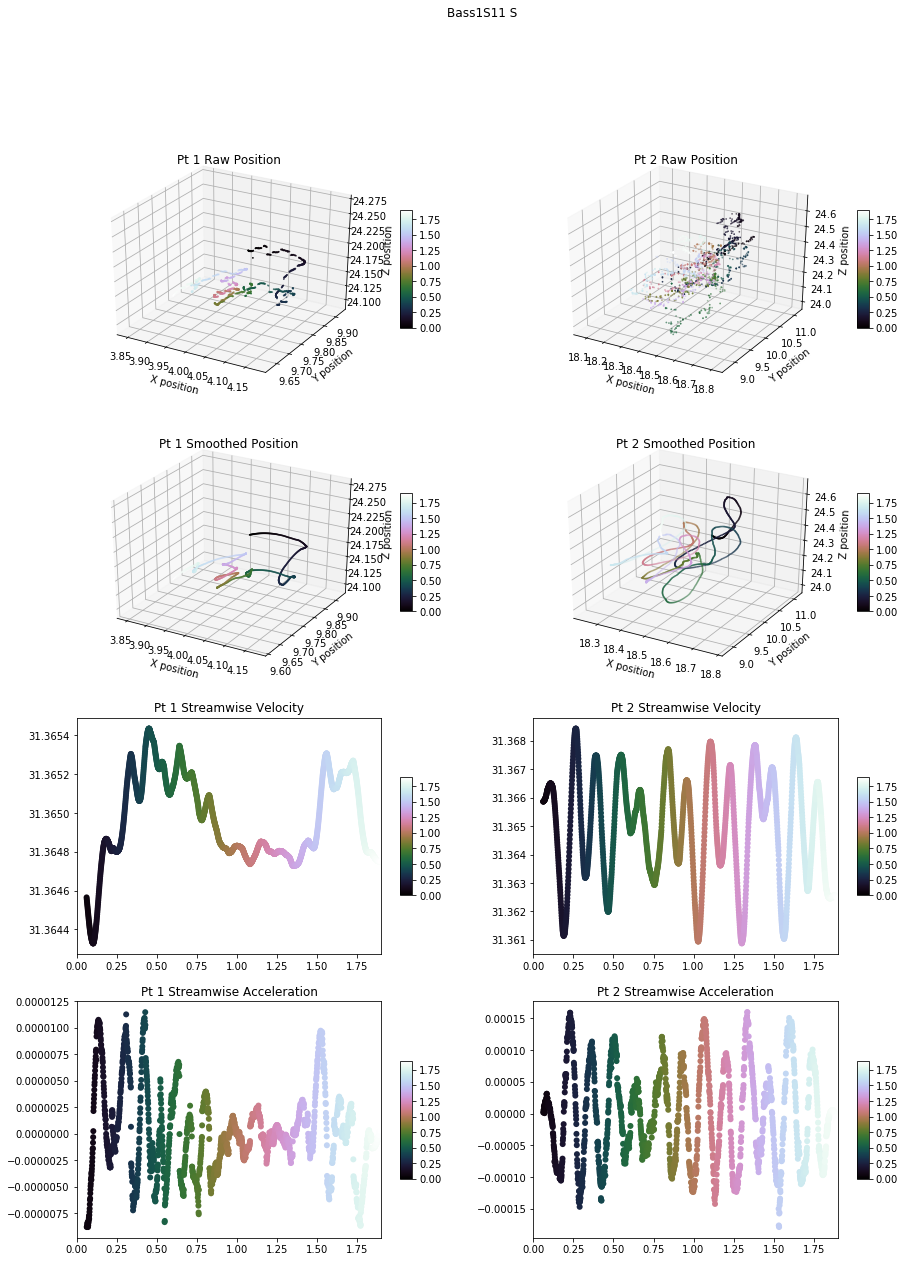

In [63]:
plot_tracks(['Bass1S11'], tracklist)


In [64]:
# Load all of the things
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('axes.formatter', useoffset=False)


def plot_accel(tracklist_subset, tracklist):
    """Plot _____ from data as produced
            by process_points_pandas.py.

           Parameters
           ----------
           tracklist_subset : 1D array_like
               List of strings indicating sequence names of desired trials.
           tracklist : pandas dataframe
               tracklist dataframe produced by process_points_pandas.py

           Returns
           -------

           Notes
           -----


           References
           ----------

           Examples
           --------
           """
    for trial in tracklist_subset:  # Iterates over all available trials

        # Scale time for colormap
        scaled_time = (tracklist[trial]['data'].index.values -
                       tracklist[trial]['data'].index.values.min()) / \
                      tracklist[trial]['data'].index.values.ptp()
        timemax = max(tracklist[trial]['data'].index.values)
        data = tracklist[trial]['data']

        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(tracklist[trial]['sequence'] + ' ' +
                     tracklist[trial]['behavior'])
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(data.index.values, data['pt2y_smth'], 'bo')
        ax1.set_ylabel('Tail Excursion (cm)', color='b')
        ax1.tick_params('y', colors='b')
        ax2 = ax1.twinx()
        ax2.plot(data.index.values, data['pt1x_a'], 'r.')
        ax2.set_ylabel('Streamwise accel (cm/s2)', color='r')
        ax1.set_xlabel('Time (s)')
        ax2.tick_params('y', colors='r')
        plt.axhline(0, color='r', linewidth=4, linestyle='dashed')
        plt.show()

In [65]:
# Load all of the things
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('axes.formatter', useoffset=False)


def plot_accel(tracklist_subset, tracklist):
    """Plot _____ from data as produced
            by process_points_pandas.py.

           Parameters
           ----------
           tracklist_subset : 1D array_like
               List of strings indicating sequence names of desired trials.
           tracklist : pandas dataframe
               tracklist dataframe produced by process_points_pandas.py

           Returns
           -------

           Notes
           -----


           References
           ----------

           Examples
           --------
           """
    for trial in tracklist_subset:  # Iterates over all available trials

        # Scale time for colormap
        scaled_time = (tracklist[trial]['data'].index.values -
                       tracklist[trial]['data'].index.values.min()) / \
                      tracklist[trial]['data'].index.values.ptp()
        timemax = max(tracklist[trial]['data'].index.values)
        data = tracklist[trial]['data']

        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(tracklist[trial]['sequence'] + ' ' +
                     tracklist[trial]['behavior'])
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(data.index.values, data['pt2y_smth'], 'bo')
        ax1.set_ylabel('Tail Excursion (cm)', color='b')
        ax1.tick_params('y', colors='b')
        ax2 = ax1.twinx()
        ax2.plot(data.index.values, data['pt1x_a'], 'r.')
        ax2.set_ylabel('Streamwise accel (cm/s2)', color='r')
        ax1.set_xlabel('Time (s)')
        ax2.tick_params('y', colors='r')
        plt.axhline(0, color='r', linewidth=4, linestyle='dashed')
        plt.show()

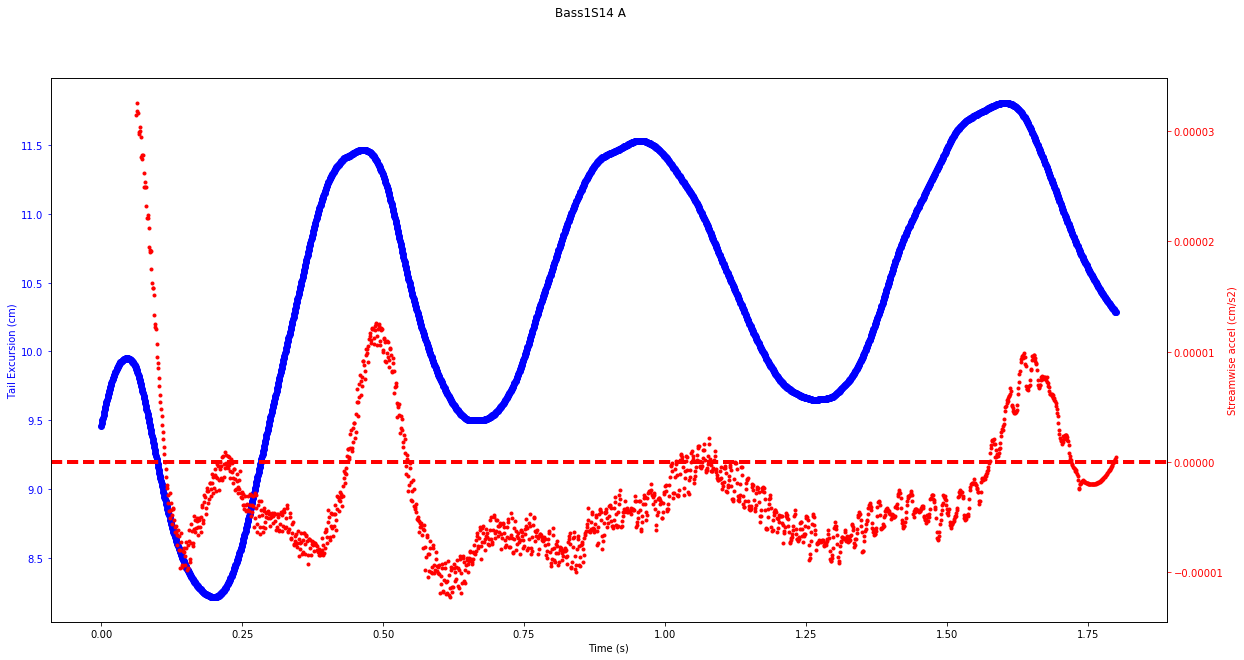

In [66]:
plot_accel(['Bass1S14'], tracklist)

In [67]:
from __future__ import division, print_function
# Load all of the things
import tkinter as tk
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib
import sys
import matplotlib.pyplot as plt
import peakutils
from scipy.signal import savgol_filter  # for smoothing data
from mpl_toolkits.mplot3d import Axes3D
from tkinter import filedialog  # For folder input popup
from peakutils.plot import plot as pplot
matplotlib.rc('axes.formatter', useoffset=False)

root = tk.Tk()
root.withdraw()

def finbeat_calc(tracklist_subset, tracklist):
    tail_amplitudes = {}
    tail_periods = {}

    for trial in tracklist_subset:  # Iterate over desired trials
        trial_name = tracklist[trial]['sequence']
        print(trial_name)
        fish = tracklist[trial]['fish']
        tailtip = tracklist[trial]['data']['pt2y_smth']
        time = tracklist[trial]['data'].index.values
        base = peakutils.baseline(tailtip, 1)  # Find linear bkgrd trend
        framerate = tracklist[trial]['FPS']

        # Find best guess for number of peaks using FFT
        fourier = np.fft.fft(tailtip)
        frequencies = np.fft.fftfreq(len(time), 1/framerate)
        positive_frequencies = frequencies[np.where(frequencies >= 0)]
        magnitudes = abs(fourier[np.where(frequencies >= 0)])
        peak_frequency = np.argmax(magnitudes)
        guess = max(time)*peak_frequency  # fb num = fb_frq*trial_length

        # First shot with peakutils
        clean_tailtip = tailtip.reset_index(drop = True)
        indexes = peakutils.indexes(clean_tailtip-base, thres=0.3, min_dist=50)
        print(indexes)
        print(time[indexes], tailtip[time[indexes]])
        plt.figure(figsize=(10, 6))
        pplot(time, clean_tailtip-base, indexes)
        plt.title('First estimate')

Bass1S18
[ 225  653 1147 1875]
[ 0.225  0.653  1.147  1.875] time
0.225    21.999272
0.653    20.772466
1.147    18.880013
1.875    18.666552
Name: pt2y_smth, dtype: float64
Bass1S13
[  89  411  740 1018 1215]
[ 0.089  0.411  0.74   1.018  1.215] time
0.089    13.356662
0.411    13.882671
0.740    14.090242
1.018    14.611530
1.215    15.291114
Name: pt2y_smth, dtype: float64
Bass1S15
[ 36 716]
[ 0.036  0.716] time
0.036    18.503915
0.716    22.367103
Name: pt2y_smth, dtype: float64
Bass1S14
[  43  459  945 1588]
[ 0.043  0.459  0.945  1.588] time
0.043     9.948215
0.459    11.462611
0.945    11.524944
1.588    11.793051
Name: pt2y_smth, dtype: float64
Bass1S17
[ 426  960 1460]
[ 0.426  0.96   1.46 ] time
0.426    14.700379
0.960    14.725167
1.460    14.837914
Name: pt2y_smth, dtype: float64
Bass1S11
[ 128  408  691  971 1242 1505 1781]
[ 0.128  0.408  0.691  0.971  1.242  1.505  1.781] time
0.128    10.723861
0.408    10.805666
0.691    10.904541
0.971    11.056232
1.242    11.0848

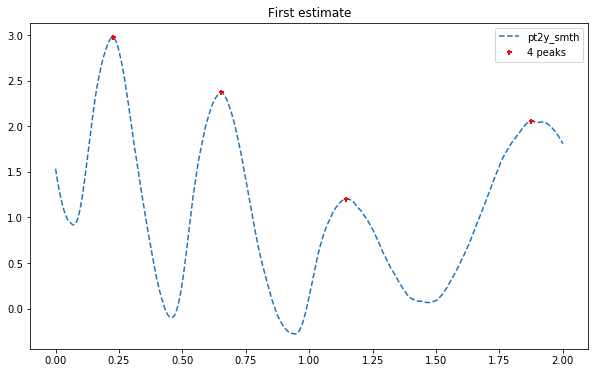

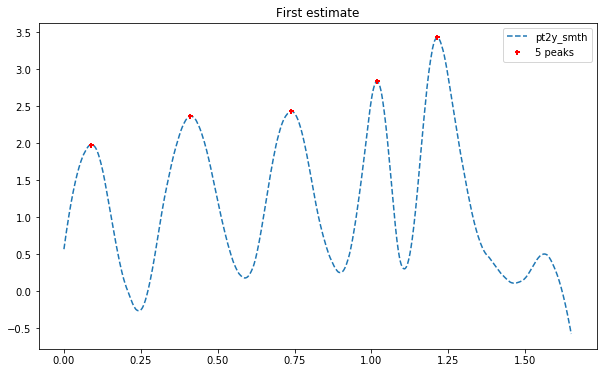

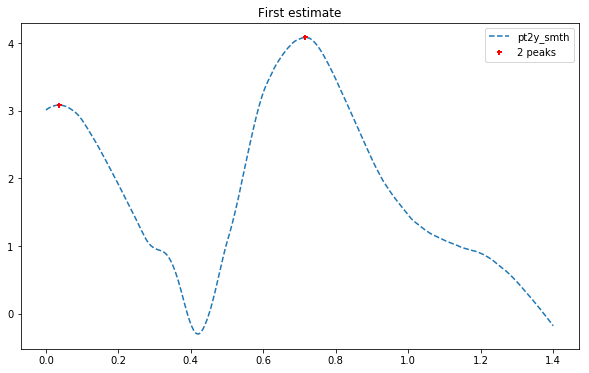

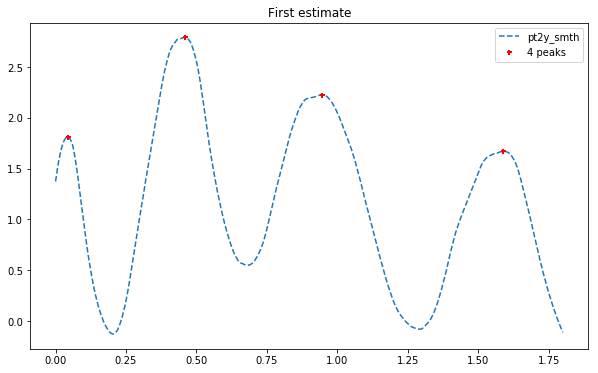

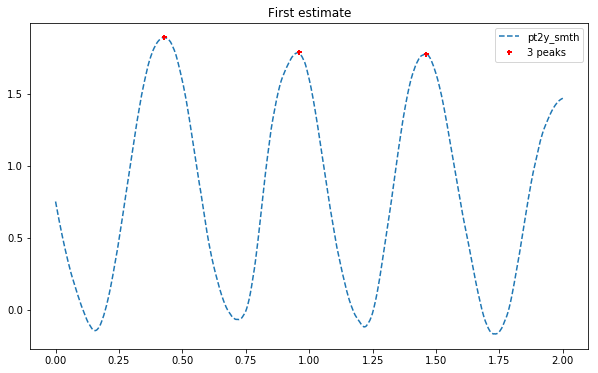

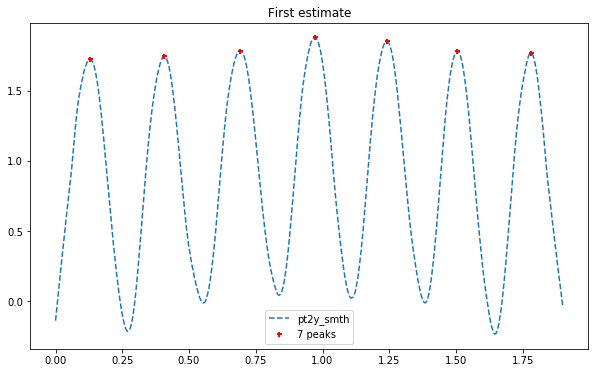

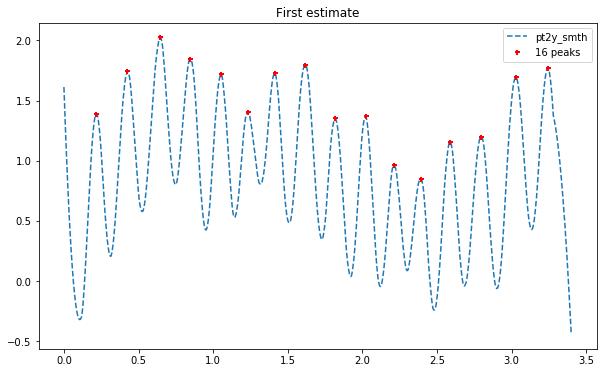

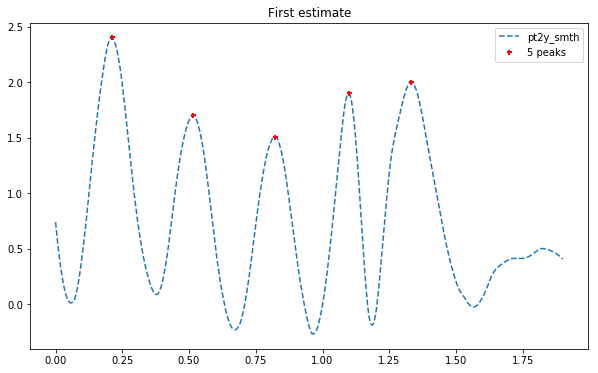

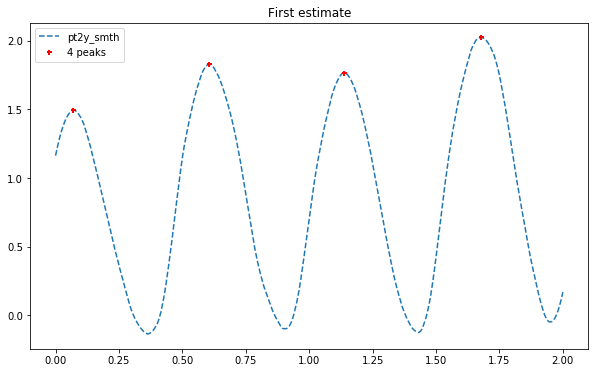

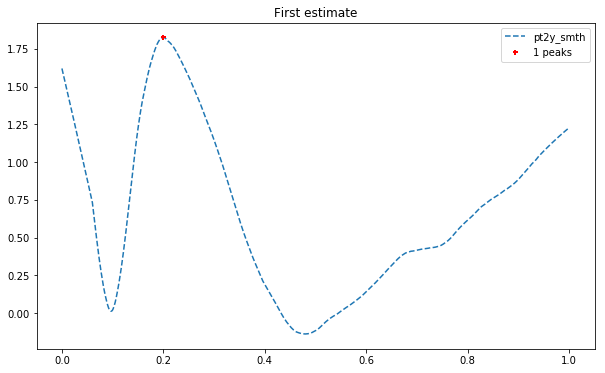

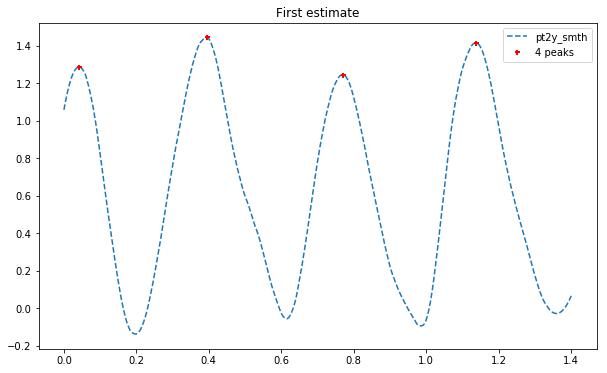

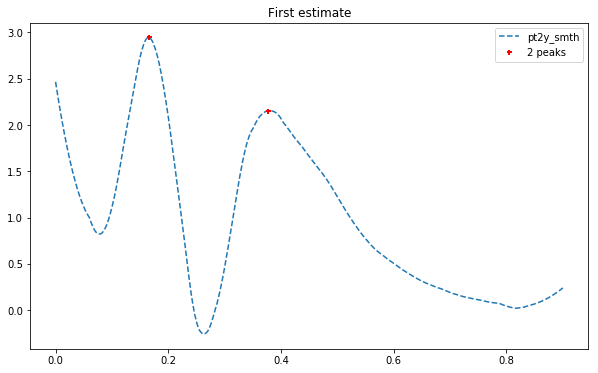

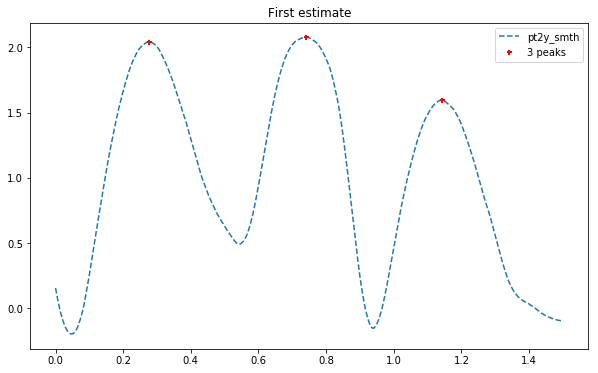

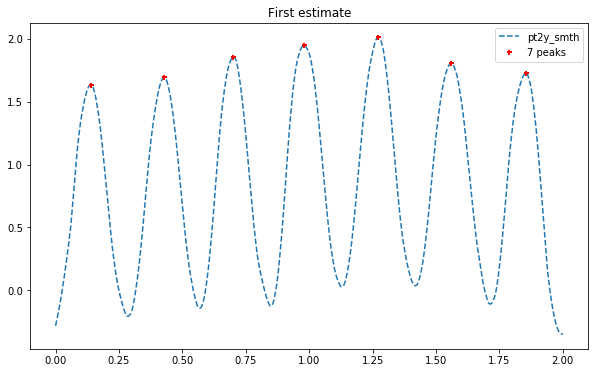

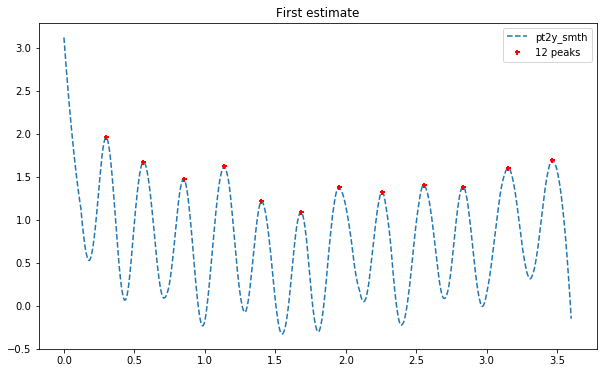

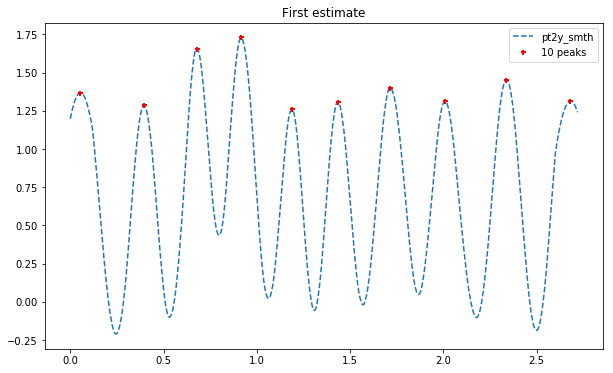

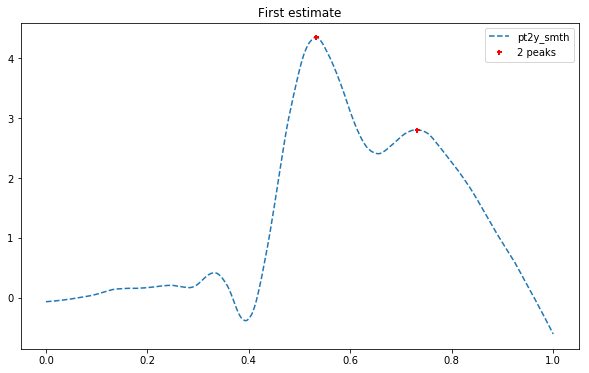

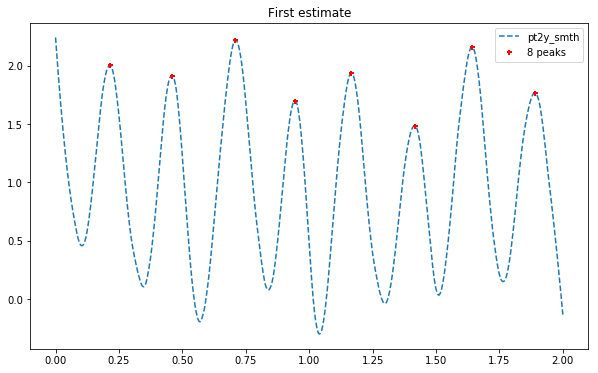

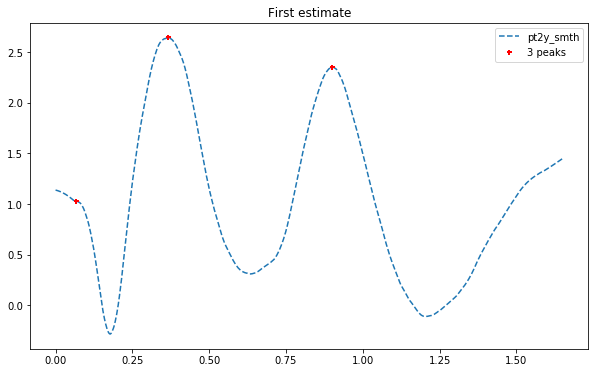

In [68]:
finbeat_calc(tracklist.keys(), tracklist)

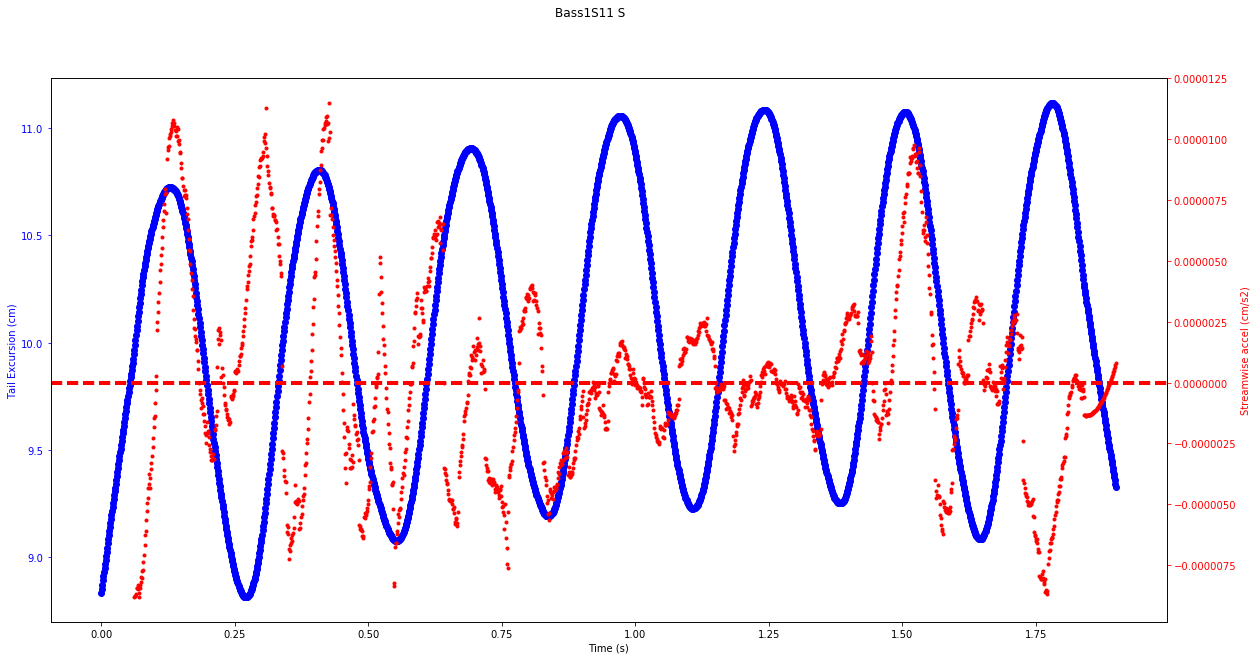

In [69]:
plot_accel(['Bass1S11'],tracklist)